In [375]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Helper Functions

In [376]:
def add_noise(df, scale):
    noise = pd.DataFrame(np.random.normal(loc=0, scale=scale, size=df.shape), columns=df.columns)

    df_noisy = noise.add(df)

    return df_noisy

In [377]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values.astype(np.float32)).to(device)

# Prepare Data

In [378]:
# read data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

In [379]:
# scale spectrum data
data_scale = 10**12
spectrum_train = spectrum_train.multiply(data_scale)
spectrum_test = spectrum_test.multiply(data_scale)

In [380]:
# set train and test data

# 1 - noise added to training data
# 0 - no noise added
noise_scale = 10
noise = 0

if noise:
    temp_train = add_noise(temp_train, noise_scale)

x_train = temp_train
x_test = temp_test
y_train = spectrum_train
y_test = spectrum_test

In [381]:
# create input and output tensors for the forward model
x = df_to_tensor(x_train)
y = df_to_tensor(y_train)

In [382]:
n_samples, middle_size = x.shape
_, io_size = y.shape
# middle_size = 66, io_size = 11
print(f'x shape: {x.shape}')
print(f'y shape: {y.shape}')

x shape: torch.Size([2000, 11])
y shape: torch.Size([2000, 66])


# Design Model 

### Forward Model — middle_size to i/o_size

In [383]:
class ForwardNet(nn.Module):
    def __init__(self, middle_size, io_size):
        super(ForwardNet, self).__init__()
        self.lin1 = nn.Linear(middle_size, 30)
        self.lin2 = nn.Linear(30, 30)
        self.lin_fin = nn.Linear(30, io_size)

    def forward(self, x):
        output = F.leaky_relu(self.lin1(x))
        output = F.leaky_relu(self.lin2(output))
        output = self.lin_fin(output)
        return output

In [384]:
class InverseNet(nn.Module):
    def __init__(self, io_size, middle_size, out_transform=nn.Sigmoid()):
        super(InverseNet, self).__init__()
        self.lin1 = nn.Linear(io_size, 30)
        self.lin2 = nn.Linear(30, 30)
        self.out = nn.Linear(30, middle_size)
        self.out_transform = out_transform

    def forward(self, y):
        h = F.leaky_relu(self.lin1(y))
        h = F.leaky_relu(self.lin2(h))
        o = self.out(h)
        if self.out_transform:
            o = self.out_transform(o)
        return o

In [385]:
class TandemNet(nn.Module):

    def __init__(self, forward_model, inverse_model):
        super(TandemNet, self).__init__()
        self.forward_model = forward_model
        self.inverse_model = inverse_model

    def forward(self, y):
        '''
        Args:
            y: true CIE coordinates
        
        Returns:
            x_: predicted structural parameters
            y_: predicted CIE coordinates for the inversely-designed structure

        '''
        pred_temp = self.inverse_model(y)
        pred_spec = self.forward_model(pred_temp)
        return pred_temp, pred_spec

In [386]:
forward_model = ForwardNet(middle_size, io_size)
inverse_model = InverseNet(io_size, middle_size)
tandem_net = TandemNet(forward_model, inverse_model)
# print(type(inverse_model(x)))
print(forward_model(inverse_model(y)))
print(tandem_net(y))

tensor([[ 0.1534,  0.0089, -0.1258,  ..., -0.0912, -0.1209, -0.1244],
        [ 0.1538,  0.0090, -0.1255,  ..., -0.0912, -0.1209, -0.1245],
        [ 0.1531,  0.0083, -0.1256,  ..., -0.0919, -0.1206, -0.1237],
        ...,
        [ 0.1532,  0.0088, -0.1258,  ..., -0.0914, -0.1209, -0.1242],
        [ 0.1537,  0.0089, -0.1256,  ..., -0.0912, -0.1209, -0.1244],
        [ 0.1533,  0.0090, -0.1260,  ..., -0.0910, -0.1210, -0.1245]],
       grad_fn=<AddmmBackward0>)
(tensor([[0.4966, 0.5565, 0.4815,  ..., 0.5167, 0.5383, 0.4632],
        [0.4991, 0.5538, 0.4810,  ..., 0.5173, 0.5396, 0.4649],
        [0.4962, 0.5700, 0.4863,  ..., 0.5231, 0.5461, 0.4534],
        ...,
        [0.4958, 0.5609, 0.4832,  ..., 0.5184, 0.5402, 0.4598],
        [0.4983, 0.5558, 0.4814,  ..., 0.5178, 0.5397, 0.4636],
        [0.4959, 0.5546, 0.4815,  ..., 0.5150, 0.5361, 0.4640]],
       grad_fn=<SigmoidBackward0>), tensor([[ 0.1534,  0.0089, -0.1258,  ..., -0.0912, -0.1209, -0.1244],
        [ 0.1538,  0.0090, -

# Construct Loss and Optimizer

In [387]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer_forward = torch.optim.Rprop(forward_model.parameters(), lr=learning_rate)
optimizer_tandem = torch.optim.Rprop(inverse_model.parameters(), lr=learning_rate)

# Training Loop

In [388]:
def train_forward_model(forward_model, x, y):

    forward_loss_list = []
    num_forward_epochs = 10000

    for epoch in range(num_forward_epochs):
        # forward pass and loss
        y_predicted = forward_model(x)
        loss = criterion(y_predicted, y)
        forward_loss_list.append(loss.item())

        # backward pass
        loss.backward()

        # update
        optimizer_forward.step()

        # empty gradients
        optimizer_forward.zero_grad()

        if (epoch+1) % int(num_forward_epochs/10) == 0:
            print(f'forward epoch: {epoch+1}, forward loss = {loss:.4f}')

    return num_forward_epochs, forward_loss_list

In [389]:
def train_tandem_model(inverse_model, forward_model, x, y):

    tandem_loss_list = []
    inverse_loss_list = []
    num_tandem_epochs = 10000

    for epoch in range(num_tandem_epochs):
        # forward pass and loss
        x_predicted = inverse_model(y)
        y_predicted = forward_model(x_predicted)
        loss = criterion(y_predicted, y)
        tandem_loss_list.append(loss.item())

        # calculate the inverse loss (what we care about)
        inverse_loss = criterion(x_predicted, x)
        inverse_loss_list.append(inverse_loss.item())


        # backward pass
        loss.backward()

        # update
        optimizer_tandem.step()

        # empty gradients
        optimizer_tandem.zero_grad()

        if (epoch+1) % int(num_tandem_epochs/10) == 0:
            print(f'tandem epoch: {epoch+1}, tandem loss = {loss:.4f}, INVERSE LOSS = {inverse_loss:.4f}')

    return num_tandem_epochs, tandem_loss_list, inverse_loss_list, x_predicted

In [390]:
num_forward_epochs, forward_loss_list = train_forward_model(forward_model, x, y)
num_tandem_epochs, tandem_loss_list, inverse_loss_list, x_predicted = train_tandem_model(inverse_model, forward_model, x, y)

forward epoch: 1000, forward loss = 0.0069
forward epoch: 2000, forward loss = 0.0049
forward epoch: 3000, forward loss = 0.0045
forward epoch: 4000, forward loss = 0.0028
forward epoch: 5000, forward loss = 0.0022
forward epoch: 6000, forward loss = 0.0019
forward epoch: 7000, forward loss = 0.0017
forward epoch: 8000, forward loss = 0.0016
forward epoch: 9000, forward loss = 0.0016
forward epoch: 10000, forward loss = 0.0016
tandem epoch: 1000, tandem loss = 1195.9038, INVERSE LOSS = 104315.6094
tandem epoch: 2000, tandem loss = 1195.9038, INVERSE LOSS = 104315.6094
tandem epoch: 3000, tandem loss = 1195.9038, INVERSE LOSS = 104315.6094
tandem epoch: 4000, tandem loss = 1195.9038, INVERSE LOSS = 104315.6094
tandem epoch: 5000, tandem loss = 1195.9038, INVERSE LOSS = 104315.6094
tandem epoch: 6000, tandem loss = 1195.9038, INVERSE LOSS = 104315.6094
tandem epoch: 7000, tandem loss = 1195.9038, INVERSE LOSS = 104315.6094
tandem epoch: 8000, tandem loss = 1195.9038, INVERSE LOSS = 10431

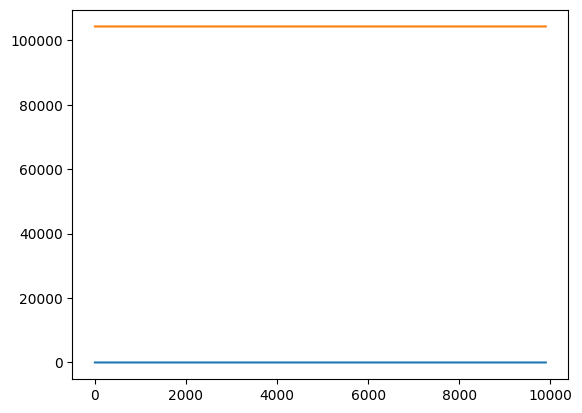

In [391]:
# plot forward and inverse loss
plt.plot(forward_loss_list[100:num_forward_epochs])
plt.plot(inverse_loss_list[100:num_tandem_epochs])

# Plots

### Clean

In [392]:
pred = x_predicted
print(pred)
pred = pd.DataFrame(pred.detach().numpy())
actual = x_test

tensor([[1., 0., 0.,  ..., 0., 1., 1.],
        [1., 0., 0.,  ..., 0., 1., 1.],
        [1., 0., 0.,  ..., 0., 1., 1.],
        ...,
        [1., 0., 0.,  ..., 0., 1., 1.],
        [1., 0., 0.,  ..., 0., 1., 1.],
        [1., 0., 0.,  ..., 0., 1., 1.]], grad_fn=<SigmoidBackward0>)


In [393]:
import matplotlib.pyplot as plt
import random

def plot_actual_vs_pred(index):
    actual_np = actual.values[index]
    pred_np = pred.values[index]

    plt.plot(x_train.columns, actual_np, label='actual')
    plt.plot(x_train.columns, pred_np, 'r+', label='predicted')

    plt.title("Spectrum to Temperature")
    plt.xlabel("Silica Layer")
    plt.ylabel("Temperature (K)")
    
    plt.legend()
    plt.show()

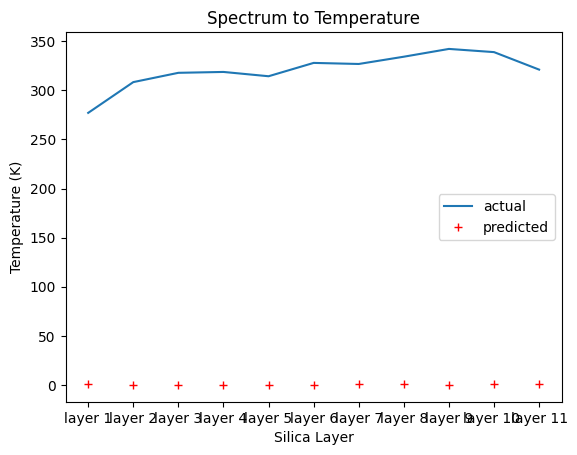

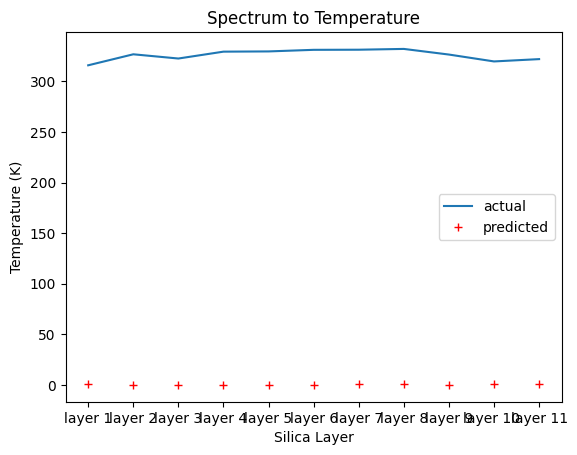

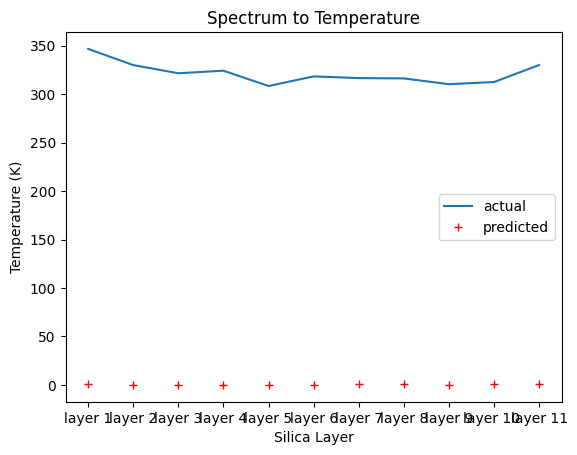

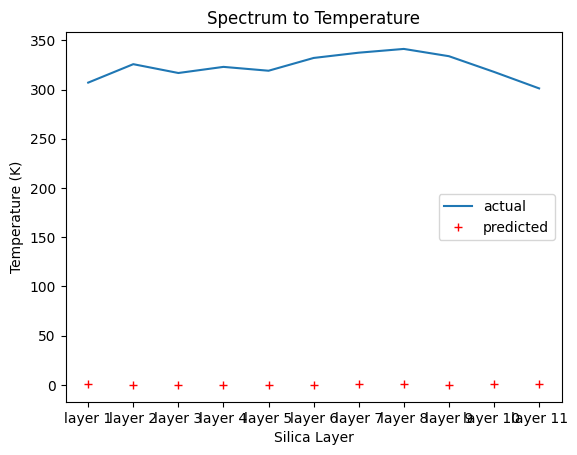

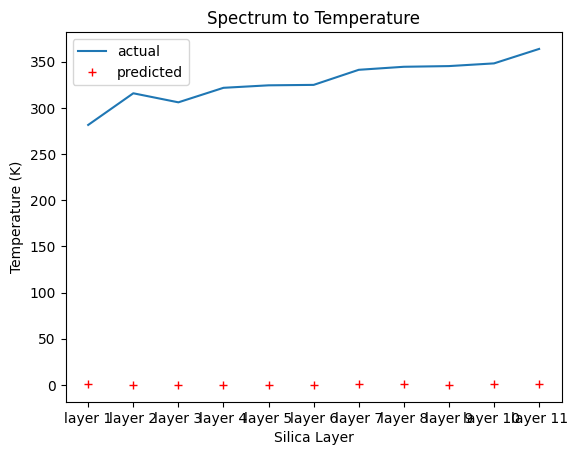

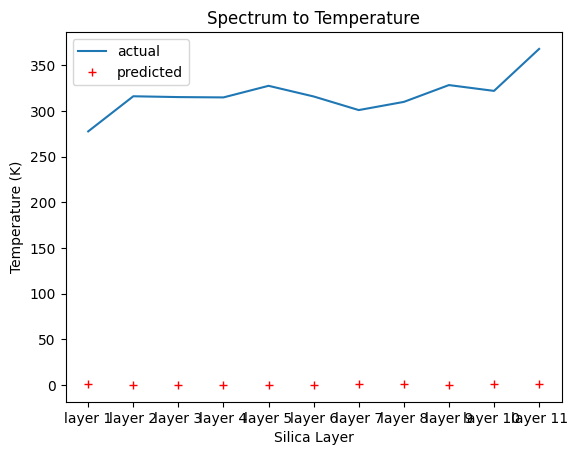

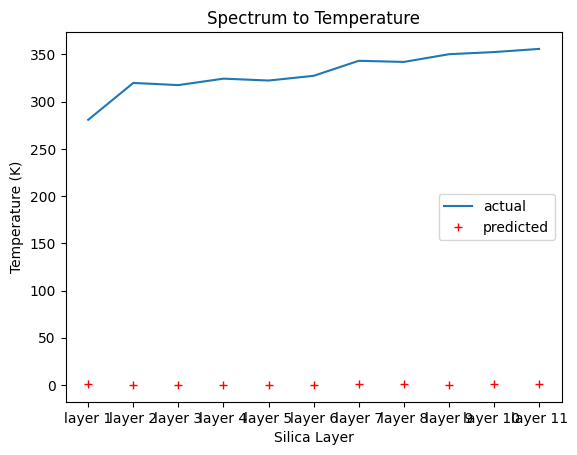

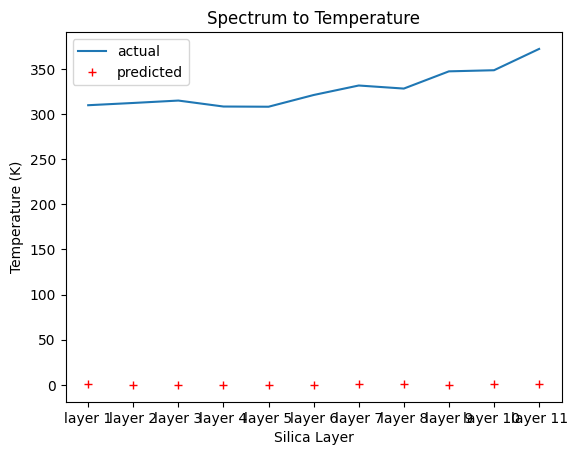

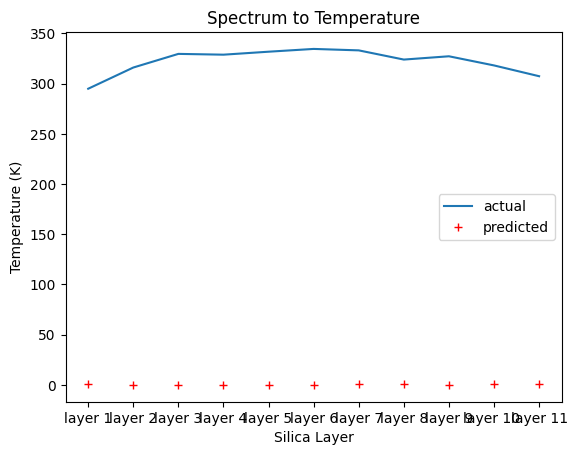

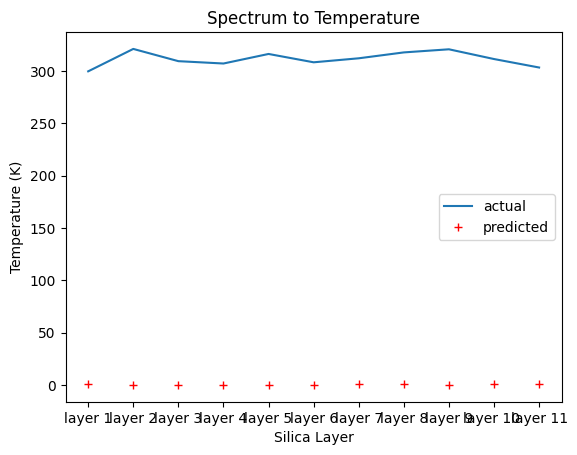

In [394]:
for index in range(10):
    plot_actual_vs_pred(index*10)